<a href="https://colab.research.google.com/github/prajwalwanjari/Design_optimization_assignments/blob/main/MAE598_HW5_PrajwalWanjari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MAE 598 : Design Optimization

Prajwal Wanjari

1222575718

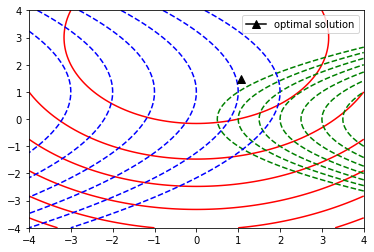

Solution for this problem is: X=(1.059953212738037,1.456347942352295)
The minimum value of objective function is 3.5063624382019043
The inequality constraints are: 
 g1=0.0010428428649902344 
 g2=-9.49198055267334


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch 


# Objective Functions and Inequality Constraints
obj = lambda x: x[0]**2 + (x[1] - 3)**2
g1 = lambda x: x[1]**2 - 2*x[0]
g2 = lambda x: (x[1]-1)**2 + 5*x[0]-15
df_obj  = lambda x : torch.tensor([[2*x[0], 2*(x[1]-3)]])
df_g1 = lambda x : torch.tensor([[-2, 2*x[1]]])
df_g2 = lambda x: torch.tensor([[5, 2*(x[1]-1)]])


def PenaltyWeights(mu, weights,k):
  if k > 0:
    #For rest of the iterations
    weights = torch.max(abs(mu), 0.5 *(weights + abs(mu)))    
  else:
    #For first iteration   
    weights = abs(mu)     
  return weights


def F_alpha(x,weights,alpha,s):
  # constraint 1
  G1=max(0, g1(x + alpha*s)) 
  # constraint 2
  G2=max(0, g2(x + alpha*s))
  # Merit Function Equation 
  return obj(x + alpha*s) +  weights[0,:] * G1 + weights[1,:]* G2 


def ArmijiloLineSearch(x,mu,weights,s,k):
    t = 0.4
    alpha = 1
    weights = PenaltyWeights(mu, weights,k)
    if g1(x) <= 0:
       dg1_da = 0
    else:
      dg1_da= torch.matmul(df_g1(x), s)

    if g2(x) <= 0:
       dg2_da = 0
    else:
      dg2_da= torch.matmul(df_g2(x), s)

    dF_da = torch.matmul(df_obj(x), s) + (weights[0, :]*dg1_da + weights[1, :]*dg2_da)

    phi = lambda x, weights, alpha, t, dF_da: F_alpha(x, weights, 0, 0) + alpha*t*dF_da

    while phi(x, weights, alpha, t, dF_da) < F_alpha(x, weights, alpha, s):
        alpha = 0.5 * alpha
    return alpha, weights


def BFGS(x,W, s, mu, alpha):
  lx_k = df_obj(x) + torch.matmul(mu.T, torch.tensor([g1(x),g2(x)]))
  lx_k_1 = df_obj(x + alpha*s) + torch.matmul(mu.T, torch.tensor([g1(x + alpha*s),g2(x + alpha*s )]))

  delta_l = lx_k_1 -lx_k
  
  Q = torch.matmul(torch.matmul((alpha*s).T, W), (alpha*s))
  if torch.matmul((alpha*s).T, delta_l.T) >= 0.2 * torch.matmul(torch.matmul((alpha*s).T, W), (alpha*s)):
        theta = 1
  else:
        theta = 0.8 * Q / (Q - torch.matmul((alpha*s).T, delta_l.T))
  y = theta * delta_l.T + (1 - theta) * torch.matmul(W, (alpha*s))
  W = W + torch.matmul(y, y.T) / torch.matmul(y.T, s) - torch.matmul(torch.matmul(W, s), torch.matmul(s.T, W)) / torch.matmul(torch.matmul(s.T, W), s)
  return W


def MuCheck(mu,active):
    mu_check = 0
    if len(mu) == 0 or min(mu) > 0:
        mu_check  = 1
    else:
        mu_idx = np.argmin(np.array(mu))
        mu = mu[mu!=min(mu)]
        active.pop(mu_idx)
    return active, mu_check ,mu
     

def solve_sqp(x, W):
    active = []
    A_0 = torch.cat((df_g1(x),df_g2(x)),0)
    B_0 = torch.tensor([[g1(x), g2(x)]]).T
    mu_0 = torch.zeros((B_0.shape[0], 1))
    mu = []
    while True:
      if len(active) == 0:
            s_mu = torch.matmul(torch.linalg.inv(W), -df_obj(x).T)
            s = s_mu[:2, :]
      if len(active) > 0:
        if len(active) == 1:
                A = A_0[active[0], :].reshape(1, -1)
                B = B_0[active[0], :].reshape(1,1)
        if len(active) == 2:
                A = A_0
                B = B_0
                
        Z = torch.zeros((A.shape[0], A.shape[0]))
        matrix=torch.cat((torch.cat((W,A.T),1),torch.cat((A,Z),1)),0)
        j=torch.cat((-df_obj(x).T,-B),0)
        s_mu = torch.matmul(torch.linalg.inv(matrix), j)
        s = s_mu[:2, :]
        mu = s_mu[2:, :]

      if len(mu) == 1:
          mu_0[0] = s_mu[2:3, :]
      if len(mu) == 2:
          mu_0[0] = s_mu[2:3, :]
          mu_0[1] = s_mu[3:, :]

      sqp_constraint = torch.round((torch.matmul(A_0, s.reshape(-1, 1)) + B_0))
      active, mu_check,mu = MuCheck(mu,active)

      if torch.max(sqp_constraint) <= 0 and mu_check == 1:
            return s, mu_0
      else:
          index = np.argmax(sqp_constraint)
          active.append(index)
          active = np.unique(np.array(active)).tolist()


x = torch.tensor([[1,1.]]).T
x_initial = x
mu = torch.zeros((x.shape[0], 1))
weights = torch.zeros((x.shape[0], 1))+2
W = torch.eye(x.shape[0])
eps = 1e-4
k = 0


delta_L_norm = np.linalg.norm(df_obj(x) + np.matmul(mu.T, torch.cat((df_g1(x),df_g2(x)),0)))
weights_old = np.zeros((2, 1))
solution1 = []
solution2 = []
solution1.append(x[0][0])
solution2.append(x[1][0])


while delta_L_norm > eps:
    s, mu = solve_sqp(x, W)
    a, weights = ArmijiloLineSearch(x,mu,weights,s,k)
    weights_old = weights
    W = BFGS(x,W, s, mu, a) 
    x += a*s
    k += 1
    delta_L_norm = np.linalg.norm(df_obj(x) + np.matmul(mu.T, torch.cat((df_g1(x),df_g2(x)),0)))
    mu_old = a


X1 = np.linspace(-4, 4, 81)
X2 = np.linspace(-4, 4, 81)
x1, x2 = np.meshgrid(X1, X2)


F = np.array([x1 ** 2 + (x2 - 3) ** 2 for x2 in X2 for x1 in X1]).reshape(x1.shape)
G1 = np.array([-2 * x1 + x2 ** 2 for x2 in X2 for x1 in X1]).reshape(x1.shape)
G2 = np.array([5 * x1 + (x2 - 1) ** 2 - 15 for x2 in X2 for x1 in X1]).reshape(x1.shape)


G1[np.where(G1 > 0)] = None
G2[np.where(G2 > 0)] = None


plt.figure(1)
plt.contour(x1, x2, F, colors='r')
plt.contour(x1, x2, G1, colors='g')
plt.contour(x1, x2, G2, colors='b')
plt.plot(solution1, solution2, c='k')
#plt.plot(x0[0], x0[-1], c='coral', marker='*', markersize='10', label='starting point')
plt.plot(x[0][0], x[1][0], c='k', marker='^', markersize='8', label='optimal solution')
plt.legend()
plt.show()


print(f'Solution for this problem is: X=({x[0][0]},{x[1][0]})')
print(f'The minimum value of objective function is {obj([x[0][0],x[1][0]])}')
print(f'The inequality constraints are: \n g1={g1([x[0][0],x[1][0]])} \n g2={g2([x[0][0],x[1][0]])}')